In [131]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'ggplot' ) 

In [132]:
import pandas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.cross_validation import cross_val_predict, cross_val_score
import numpy as np 
from scipy.stats import pearsonr

In [133]:
paths = [ 
    '../rosetta_runs/benchmark/feature_set.csv', 
    '../rosetta_runs/shells/feature_set.csv',
    '../rosetta_runs/ddg_monomer/feature_set.csv', 
    '../foldx_runs/pssm/feature_set.csv', 
    # '../rosetta_runs/homology_models/feature_set.csv', 
]

In [134]:
dat = pandas.read_csv( '../data_sets/experimental/plos_2016.csv', index_col=0 )
dat.kcat = np.log10( dat.kcat / 880 )
dat.km = np.log10( dat.km / 5.5 )
dat.kcatkm = np.log10( dat.kcatkm / 174000 )
dat = dat.replace( [ np.inf, -np.inf ], -5 )

In [135]:
fancy_targets = [ 
    ( 0, 'kcat', r'$k_{\mathrm{cat}}$', 'navy' ), 
    ( 1, 'km', r'$K_{\mathrm{M}}$', 'purple' ), 
    ( 2, 'kcatkm', r'$k_{\mathrm{cat}}/K_{\mathrm{M}}$', 'magenta' ), 
    #( 3, 'tm', '$T_{\mathrm{{m}}$', 'lightblue' ), 
]

In [136]:
en_preds = []
for feature_set in paths:
    feats = pandas.read_csv( feature_set, index_col=0 )
    for index, short_name, fmt_str, color in fancy_targets:
        J = dat[[ short_name ]].join( feats ).dropna()
        scaler = MinMaxScaler()
        X = scaler.fit_transform( J )
        y = J.ix[ : , 0 ].ravel()
        X = X[ : , 1: ] 
        net = ElasticNetCV( cv=10, max_iter=1e9 )
        net.fit( X, y ) 
        preds = net.predict( X )
        score = pearsonr( preds, y ) 
        coefs = zip( J.columns[ 1: ], net.coef_ ) 
        en_preds.append( ( X, y, preds, score, color, feature_set, net, coefs ) ) 

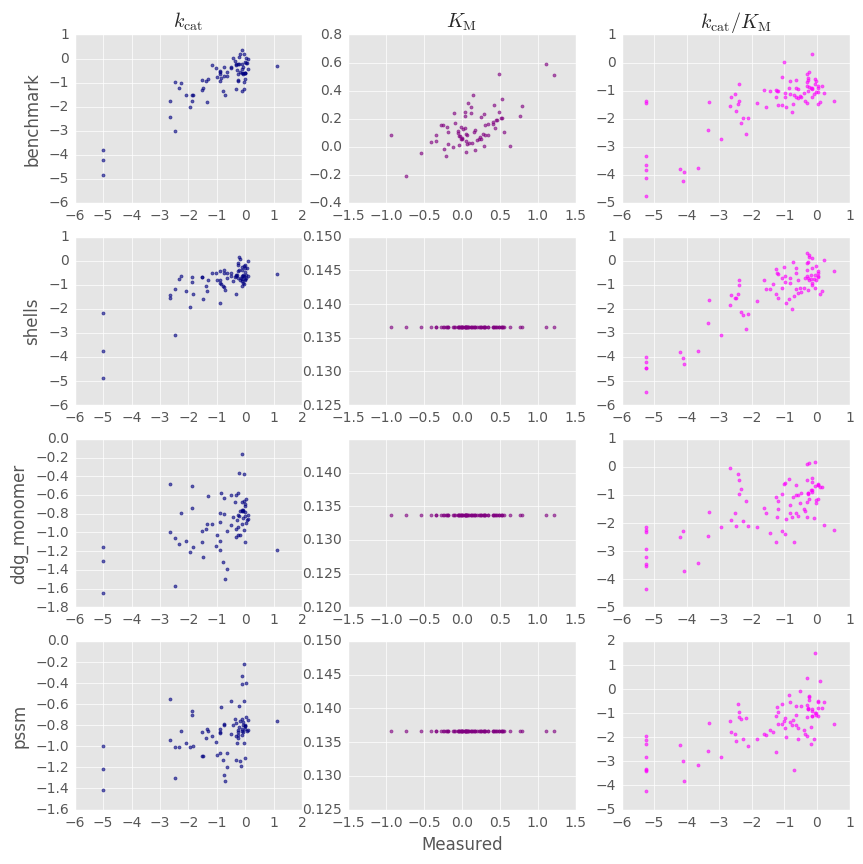

In [137]:
plt.figure( figsize=( 10, 10 ) ) 

for i, (X, y, preds, score, color, feature_set, net, coefs ) in enumerate( en_preds ):
    
        nm = feature_set.split( '/' )[ 2 ] 
        plt.subplot( 4, 3, i+1 )
        
        if i == 0:
            plt.title( '$k_{\mathrm{cat}}$' )
            plt.ylabel( nm ) 
        elif i == 1:
            plt.title( '$K_\mathrm{M}$' )
        elif i == 2:
            plt.title( '$k_{\mathrm{cat}}/K_\mathrm{M}$' ) 
        elif i % 3 == 0:
            plt.ylabel( nm ) 
        elif i == 10:
            plt.xlabel( 'Measured' ) 
        else:
            pass
        
        plt.scatter( y, preds, marker='.', color=color, alpha=.6 )
        
plt.show()

In [138]:
# feature weights 

my_rows = []

for i, (X, y, preds, score, color, feature_set, net, coefs ) in enumerate( en_preds ):
    for feature, weight in coefs:
        my_rows.append( ( feature, weight, feature_set.split( '/' )[ 2 ] ) ) 
        
df = pandas.DataFrame( my_rows, columns=[ 'feature', 'weight', 'feature_set' ] )

In [141]:
for key, d in df.groupby( 'feature_set' ):
    print( key )

benchmark
ddg_monomer
pssm
shells
